In [69]:
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans
from imblearn.over_sampling import SVMSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from utils import clean_predictor
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.svm import LinearSVC

def model(X_train, y_train, df_test, predict_true, 
          ovs1, ovs2,
          smote_random, pca_random, ext_random,
          min_samples_leaf,
          min_samples_split,
          n_estimators, indice
          ):
    ### 1. OVERSAMPLING CLASS 2 AND 1
    ovs_strat = {1: ovs1, 2: ovs2}

    # Oversampling
    svmsmote = SVMSMOTE(sampling_strategy=ovs_strat, random_state=smote_random)
    X_train_synth, y_train_synth = svmsmote.fit_resample(X_train, y_train)
    X_train_synth = pd.DataFrame(X_train_synth, columns=X_train.columns)


    #### 2. NON-LINEAR FEATURES
    # Cross-features
    mult_combinator = {"Horizontal_Distance_To_Fire_Points": ["Id", "Elevation", "Horizontal_Distance_To_Roadways"],
                    "Elevation" : ["Id", "Horizontal_Distance_To_Roadways"]}

    new_cols = []
    for key in mult_combinator:
        for value in mult_combinator[key]:
            new_cols.append(f"{key} * {value}")
            df_test[f"{key} * {value}"] = df_test[key] * df_test[value]    
            X_train_synth[f"{key} * {value}"] = X_train_synth[key] * X_train_synth[value]   

    # Log features
    log_combinator = ['Id', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']

    for label in log_combinator:
        temp = np.where(df_test[label] > 0.5, df_test[label], -10)
        df_test[f"log({label})"] = np.log(temp, where=temp > 0.5)
        temp = np.where(X_train_synth[label] > 0.5, X_train_synth[label], -10)
        X_train_synth[f"log({label})"] = np.log(temp, where=temp > 0.5)
        X_train_synth[X_train_synth.isna().any(axis=1)][f"log({label})"] = -10

    ### 3. UNSUPERVISED LEARNING 
    
    # KMEANS - Without ID
    km = KMeans(n_clusters=30, n_init=5, init="k-means++")
    df_test["kmean"] = km.fit_predict(df_test.loc[:, "Elevation":])# "Horizontal_Distance_To_Fire_Points"])
    X_train_synth["kmean"] = km.predict(X_train_synth.loc[:, "Elevation":])# "Horizontal_Distance_To_Fire_Points"])

    # PCA - With ID
    pca_1 = PCA(n_components=4, random_state=pca_random)
    pca_cols_1 = ["PCA_1", "PCA_2", "PCA_3", "PCA_4"]
    df_test.loc[:, pca_cols_1] = pca_1.fit_transform(df_test.loc[:, "Id": ])#"Horizontal_Distance_To_Fire_Points"])
    X_train_synth.loc[:, pca_cols_1] = pca_1.transform(X_train_synth.loc[:, "Id": ])#"Horizontal_Distance_To_Fire_Points"])
    # Dropping PCA_1 (virtually the same as the Id column)
    df_test.drop(columns='PCA_1', inplace=True) 
    X_train_synth.drop(columns='PCA_1', inplace=True)
    
    X_train_synth.fillna(0, inplace=True)
    df_test.fillna(0, inplace=True)

    # ELU_new = {k:v['ELU']%100 for k, v in ST.items()}
    # X_train_synth['ELU'] = X_train_synth['ST_concat'].map(ELU_new)
    # family_new = {k:v['family'] for k, v in ST.items()}
    # X_train_synth['family'] = X_train_synth['ST_concat'].map(family_new)
    # stone_new = {k:v['stone'] for k, v in ST.items()}
    # X_train_synth['stone'] = X_train_synth['ST_concat'].map(stone_new)

    # df_test['ELU'] = df_test['ST_concat'].map(ELU_new)
    # df_test['family'] = df_test['ST_concat'].map(family_new)
    # df_test['stone'] = df_test['ST_concat'].map(stone_new)

    # X_train_synth.fillna("", inplace=True)
    # df_test.fillna("", inplace=True)
    
    # cat_col = ['family', 'stone']
    # encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    # encoder.fit(X_train_synth[cat_col])
    # X_train_synth = encoder.transform(X_train_synth[cat_col])
    # df_test = encoder.transform(df_test[cat_col])


    ### 4.CLASSIFYING
    print('Model..')
    # clf = ExtraTreesClassifier(n_jobs=-1, max_features=None, 
    #                            min_samples_leaf=min_samples_leaf,
    #                            min_samples_split=min_samples_split,
    #                            n_estimators=n_estimators,
    #                            random_state=ext_random)
    estimators = [
        ('rf', RandomForestClassifier(n_estimators=150, n_jobs=-1)),
        # ('svrl1', make_pipeline(StandardScaler(),
        #                     LinearSVC(dual='auto', penalty='l1'))),
        # ('svrl2', make_pipeline(StandardScaler(),
        #                     LinearSVC(dual='auto', penalty='l2'))),
        ('xgb', xgb.XGBClassifier(n_estimators=200)),
        ('xtree', ExtraTreesClassifier(n_jobs=-1, max_features=None, 
                                min_samples_leaf=min_samples_leaf,
                                min_samples_split=min_samples_split,
                                n_estimators=n_estimators,
                                random_state=ext_random),),
        # ('ada', AdaBoostClassifier(algorithm="SAMME", n_estimators=200)),
        ('xgbrf', xgb.XGBRFClassifier(n_estimators=200)),
        ('lgbm', LGBMClassifier(objective='multiclass',
                                num_class=7,
                                boosting_type='gbdt',
                                verbose=0,
                                n_jobs=-1)
        )
    ]
    clf = StackingClassifier(
        estimators=estimators,
        # final_estimator=LogisticRegression(max_iter=500),
        final_estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1),
        stack_method='predict_proba',
        
        # LGBMClassifier(
        #     objective='multiclass',
        #     num_class=7,
        #     boosting_type='gbdt',
        #     verbose=0,
        #     n_jobs=-1
        # )
    )

    clf.fit(X_train_synth, y_train_synth)
    y_pred = clf.predict(df_test)
    predictions_df = clean_predictor(y_pred)
    accuracy = accuracy_score(predictions_df['Cover_Type'], predict_true)

    print(accuracy)
    predictions_df.to_csv(f'test_predictions{indice}_{accuracy:.5f}.csv', index=False) 
    
    # col = pd.DataFrame({'col_name': clf.feature_names_in_, 'value': clf.feature_importances_}).sort_values('value').col_name.values.tolist()
    # print(col[:5])
    
    # print('Remove features less important ...')
    # for i in range(1):
    #     print(f'Without {col[i]}')
    #     clf.fit(X_train_synth[col[i+1:]], y_train_synth)
    #     y_pred = clf.predict(df_test[col[i+1:]])
    #     predictions_df = clean_predictor(y_pred)
    #     accuracy = accuracy_score(predictions_df['Cover_Type'], predict_true)
    #     print('\t', accuracy)
    #     col1 = pd.DataFrame({'col_name': clf.feature_names_in_, 'value': clf.feature_importances_}).sort_values('value').col_name.values.tolist()
    #     print(col1[:5])
    #     predictions_df.to_csv(f'test_predictions{indice}_{accuracy:.5f}.csv', index=False) 
    return accuracy_score(predictions_df['Cover_Type'], predict_true), clf

In [70]:
from sklearn.calibration import LabelEncoder
from feature_engineering import *

def preprocess(df):
    df = concat_Soil_Type(df, drop_value=True) 
    df = concat_Wilderness_Area(df, drop_value=True) 
    df = group_climatic_zone(df)
    df = group_geological_zone(df)
    ELU_new = {k:v['ELU']%100 for k, v in ST.items()}
    df['ELU'] = df['ST_concat'].map(ELU_new)
    family_new = {k:v['family'] for k, v in ST.items()}
    df['family'] = df['ST_concat'].map(family_new)
    stone_new = {k:v['stone'] for k, v in ST.items()}
    df['stone'] = df['ST_concat'].map(stone_new)
    complex_new = {k:v['complex'] for k, v in ST.items()}
    df['complex'] = df['ST_concat'].map(complex_new)
    return df

# 1. Loading data
df_test = pd.read_csv("test-full.csv")
df_train = pd.read_csv("train.csv")
predict_true = pd.read_parquet("ground_truth.parquet")["Cover_Type"]

# 2. Preprocessing
# Un-one-hot-encoding the categorical variables
soil_types = [f"Soil_Type{i}" for i in range(1, 41)]
wilderness_areas = [f"Wilderness_Area{i}" for i in range(1,5)]
df_test["Wilderness_Area_Synth"] = df_test[wilderness_areas] @ range(1,5)
df_train["Wilderness_Area_Synth"] = df_train[wilderness_areas] @ range(1,5)
df_test["Soil_Type_Synth"] = df_test[soil_types] @ range(1,41)
df_train["Soil_Type_Synth"] = df_train[soil_types] @ range(1,41)
df_train = df_train.drop(columns=wilderness_areas + soil_types)
df_test = df_test.drop(columns=wilderness_areas + soil_types)

# df_train = preprocess(df_train)
# df_test = preprocess(df_test)


# df_train.fillna("", inplace=True)
# df_test.fillna("", inplace=True)
# cat_col = ['family', 'stone', 'complex']


# 3. Separating train 
X_train = df_train.drop(columns=['Cover_Type'], axis=1)
y_train = df_train['Cover_Type']

# le_fam = LabelEncoder()
# le_sto = LabelEncoder()
# le_cpx = LabelEncoder()

# le_fam.fit(X_train['family'])
# X_train['family'] = le_fam.transform(X_train['family'])
# df_test['family'] = le_fam.transform(df_test['family'])

# le_sto.fit(X_train['stone'])
# X_train['stone'] = le_sto.transform(X_train['stone'])
# df_test['stone'] = le_sto.transform(df_test['stone'])

# le_cpx.fit(X_train['complex'])
# X_train['complex'] = le_cpx.transform(X_train['complex'])
# df_test['complex'] = le_cpx.transform(df_test['complex'])

# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# encoder.fit(X_train[cat_col])
# X_train_enc = encoder.transform(X_train[cat_col])
# df_test_enc = encoder.transform(df_test[cat_col])

# X_train_encoded = pd.DataFrame(X_train_enc, columns=encoder.get_feature_names_out(cat_col))
# df_test_encoded = pd.DataFrame(df_test_enc, columns=encoder.get_feature_names_out(cat_col))

# X_train = pd.concat([X_train.drop(cat_col, axis=1), X_train_encoded], axis=1)
# df_test = pd.concat([df_test.drop(cat_col, axis=1), df_test_encoded], axis=1)

In [50]:
preprocess(df_train)[["ST_concat", "climatic_zone", "geological_zone", "ELU", "family", "stone", "complex"]].drop_duplicates(subset='ST_concat', keep='first').sort_values("ST_concat")

,ST_concat,climatic_zone,geological_zone,ELU,family,stone,complex
4325,1,2,7,2,Cathedral,extremely stony,Rock outcrop complex
2898,2,2,7,3,Vanet,very stony,Ratake families complex
2954,3,2,7,4,Haploborolis,rubbly,Rock outcrop complex
1943,4,2,7,5,Ratake,rubbly,Rock outcrop complex
4342,5,2,7,6,Vanet,rubbly,Rock outcrop complex
2182,6,2,7,17,Vanet,stony,Rock outcrop complex
2601,7,3,5,1,Gothic,,
268,8,3,5,2,,,Limber families complex
1595,9,4,2,1,Troutville,very stony,
594,10,4,7,3,Catamount,rubbly,Rock outcrop complex


In [71]:
# 4. Parameters 
ovs1 = 60_000
ovs2 = 93_500
smote_random = 84
pca_random = 67#np.random.randint(100)#67
ext_random = 69#np.random.randint(100)#69
min_samples_leaf = 1
min_samples_split = 2
n_estimators = 300#745

# 5. MODEL
print('Training...')
# for i in range(10):
accuracy, clf = model(X_train, y_train, df_test, predict_true, 
        ovs1=ovs1, ovs2=ovs2,
        smote_random=smote_random, pca_random=pca_random, ext_random=ext_random,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators, indice='stacking'
        )
print(accuracy)

Training...
Model..
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
0.8475229427275168
0.8475229427275168


In [61]:
X_train.columns

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'ST_concat',
       'WA_concat', 'climatic_zone', 'geological_zone', 'ELU', 'family_',
       'family_Bross', 'family_Catamount', 'family_Cathedral', 'family_Como',
       'family_Gateview', 'family_Gothic', 'family_Legault', 'family_Leighcan',
       'family_Moran', 'family_Ratake', 'family_Rogert', 'family_Troutville',
       'family_Vanet', 'stone_', 'stone_extremely bouldery',
       'stone_extremely stony', 'stone_rubbly', 'stone_stony',
       'stone_very stony'],
      dtype='object')

In [44]:
ST = {
    1: {
        "ELU": 2702,
        "family":"Cathedral", 
        "complex": "Rock outcrop complex", 
        "stone":"extremely stony",
        },
    2: {
        "ELU": 2703,
        "family":"Vanet",
        "complex": "Ratake families complex", 
        "stone":"very stony",
        },
    3: {
        "ELU": 2704,
        "family":"Haploborolis",  # peut etre pas famille..
        "complex":"Rock outcrop complex",
        "stone":"rubbly",
        },
    4: {
        "ELU": 2705,
        "family":"Ratake", 
        "complex": "Rock outcrop complex", 
        "stone":"rubbly",
        },
    5: {
        "ELU": 2706,
        "family":"Vanet",
        "complex":"Rock outcrop complex", #complex
        "stone":"rubbly",
        },
    6: {
        "ELU": 2717,
        "family":"Vanet",# Wetmore families - 
        "complex":"Rock outcrop complex", 
        "stone":"stony",
        },
    7: {
        "ELU": 3501,
        "family":"Gothic",
        "complex":"",
        "stone":"",
        },
    8: {
        "ELU": 3502,
        "family":"",#Supervisor - 
        "complex":"Limber families complex",
        "stone":"",
        },
    9: {
        "ELU": 4201,
        "family":"Troutville", 
        "complex":"",
        "stone":"very stony",
        },
    10: {
        "ELU": 4703,
        "family":"Catamount", #Bullwark - 
        "complex":"Rock outcrop complex", 
        "stone":"rubbly",
        },
    11: {
        "ELU": 4704,
        "family":"Catamount",# Bullwark - 
        "complex":"Rock land complex",
        "stone":"rubbly",
        },
    12: {
        "ELU": 4744,
        "family":"Legault",
        "complex":"Rock land complex",
        "stone":"stony",
        },
    13: {
        "ELU": 4758,
        "family":"Catamount",# - Rock land - Bullwark family complex,
        "complex":"",
        "stone":"rubbly",
        },
    14: {
        "ELU": 5101,
        "family":"",#Pachic Argiborolis - 
        "complex":"Aquolis complex",
        "stone":"",
        },
    15: {
        "ELU": 5151,
        "family":None,
        "complex":None,
        "stone":None,
        },
    16: {
        "ELU": 6101,
        "family":"",#Cryaquolis - Cryoborolis complex.
        "complex":"",
        "stone":"",
        },
    17: {
        "ELU": 6102,
        "family":"Gateview", #- Cryaquolis complex.,
        "complex":"",
        "stone":"",
        },
    18: {
        "ELU": 6731,
        "family":"Rogert",
        "complex":"",
        "stone":"very stony",
        },
    19: {
        "ELU": 7101,
        "family":"",#Typic Cryaquolis - Borohemists complex.,
        "complex":"Typic Cryaquolis",
        "stone":"",
        },
    20: {
        "ELU": 7102,
        "family":"",#Typic Cryaquepts - Typic Cryaquolls complex.,
        "complex":"Typic Cryaquolis",
        "stone":"",
        },
    21: {
        "ELU": 7103,
        "family":"Leighcan", #Typic Cryaquolls -, till substratum complex.,
        "complex":"Typic Cryaquolis",
        "stone":"",
        },
    22: {
        "ELU": 7201,
        "family":"Leighcan",  #till substratum, 
        "complex":"",
        "stone":"extremely bouldery",
        },
    23: {
        "ELU": 7202,
        "family":"Leighcan",  #till substratum - Typic Cryaquolls complex.,
        "complex":"Typic Cryaquolis",
        "stone":"",
        },
    24: {
        "ELU": 7700,
        "family":"Leighcan", 
        "complex":"",
        "stone":"extremely stony",
        },
    25: {
        "ELU": 7701,
        "family":"Leighcan", #warm, 
        "complex":"",
        "stone":"extremely stony",
        },
    26: {
        "ELU": 7702,
        "family":"Catamount", #Granile -  complex,
        "complex":"",
        "stone":"very stony",
        },
    27: {
        "ELU": 7709,
        "family":"Leighcan", #warm - 
        "complex":"Rock outcrop complex",
        "stone":"extremely stony",
        },
    28: {
        "ELU": 7710,
        "family":"Leighcan",
        "complex":"Rock outcrop complex", 
        "stone":"extremely stony",
        },
    29: {
        "ELU": 7745,
        "family":"Como",#- Legault families complex, 
        "complex":"",
        "stone":"extremely stony",
        },
    30: {
        "ELU": 7746,
        "family":"Como", #- Rock land - Legault family complex, 
        "complex":"Rock land complex",
        "stone":"extremely stony",
        },
    31: {
        "ELU": 7755,
        "family":"Catamount",# Leighcan -  complex, 
        "complex":"",
        "stone":"extremely stony",
        },
    32: {
        "ELU": 7756,
        "family":"Catamount", # - Rock outcrop - Leighcan family complex,
        "complex":"Rock outcrop complex", 
        "stone":"extremely stony",
        },
    33: {
        "ELU": 7757,
        "family":"Catamount", #Leighcan
        "complex":"Rock outcrop complex",
        "stone":"extremely stony",
        },
    34: {
        "ELU": 7790,
        "family":"",#Cryorthents - 
        "complex":"Rock land complex",
        "stone":"extremely stony",
        },
    35: {
        "ELU": 8703,
        "family":"",#Cryumbrepts - Rock outcrop - Cryaquepts complex.,
        "complex":"Rock outcrop complex",
        "stone":"",
        },
    36: {
        "ELU": 8707,
        "family":"Bross", #- Rock land - Cryumbrepts complex,
        "complex":"Rock land complex",
        "stone":"extremely stony",
        },
    37: {
        "ELU": 8708,
        "family":"",#Rock outcrop - Cryumbrepts - Cryorthents complex,
        "complex":"Rock outcrop complex",
        "stone":"extremely stony",
        },
    38: {
        "ELU": 8771,
        "family":"Moran", #- Leighcan - Cryaquolls complex,
        "complex":"Typic Cryaquolis",
        "stone":"extremely stony",
        },
    39: {
        "ELU": 8772,
        "family":"Moran", # - Cryorthents - Leighcan family complex,
        "complex":"",
        "stone":"extremely stony",
        },
    40: {
        "ELU": 8776,
        "family":"Moran", #- Cryorthents - 
        "complex":"Rock land complex",
        "stone":"extremely stony",
        },
}

In [52]:
pd.DataFrame({'col_name': clf.feature_names_in_, 'value': clf.feature_importances_}).sort_values('value').head(40)

AttributeError: 'ExtraTreesClassifier' object has no attribute 'feature_names_in_'

In [81]:
file_path = 'Submission_18.08.10-2024-02-12_good.csv'
pred = pd.read_csv(file_path)
accuracy_score(pred.Cover_Type, predict_true)


0.8029868574143046

In [78]:
pred.head()

,Id,Cover_Type
0,1,5
1,2,5
2,3,2
3,4,5
4,5,5


In [74]:
pred.Cover_Type = pred.Cover_Type+1

In [76]:
pred.to_csv('Submission_18.08.10-2024-02-12_good.csv', index=False) 

In [79]:
np.arange(0.6,0.78, 0.02)

array([0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78])

In [91]:
import numpy as np
import os
import random

folder_path = 'Predictions'
files = os.listdir(folder_path)
th = .82
preds = []

for file in files:
    file_path = os.path.join(folder_path, file)
    pred = pd.read_csv(file_path).sort_values("Id")["Cover_Type"]
    acc = accuracy_score(pred, predict_true)
    if acc>th:
        preds.append(pred)
print(len(preds))
# preds = random.sample(preds,20)
preds_arr =np.stack(preds, axis=1)

y_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=preds_arr)

predictions_df = clean_predictor(y_pred)
accuracy = accuracy_score(predictions_df['Cover_Type'], predict_true)
print(accuracy)
# predictions_df.to_csv('Final_pred_30-03.csv', index=False) 

76
0.8691782613784225


In [92]:
accuracy_score(pd.read_csv("Final_pred_best_0.86928.csv")['Cover_Type'], predict_true)

0.8692488279071688

In [81]:
import numpy as np
import os

folder_path = 'Predictions'
files = os.listdir(folder_path)
thresholds =[0.81, 0.82, 0.83, 0.84] #[0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86]
preds = {}
for th in thresholds:
    preds[th] = []

for file in files:
    file_path = os.path.join(folder_path, file)
    pred = pd.read_csv(file_path).sort_values("Id")["Cover_Type"]
    # print(file_path)
    # if len(pred) == 581012:
    #     print(file_path)
    acc = accuracy_score(pred, predict_true)
    for th in thresholds:
        if acc > th:
           preds[th].append(pred) 

    # if acc > 0.82:
    #     preds.append(pred)
    # if acc < 0.8:
    #     print(file_path, '\n\t', acc)
           
for th in thresholds:
    preds_arr = np.stack(preds[th], axis=1)

    y_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=preds_arr)

    predictions_df = clean_predictor(y_pred)
    accuracy = accuracy_score(predictions_df['Cover_Type'], predict_true)
    print(th, accuracy)
    predictions_df.to_csv('Final_pred_28-03.csv', index=False) 

0.81 0.8689940999497429
0.82 0.8690663876133368
0.83 0.8690663876133368
0.84 0.8689923788148954


In [14]:
pred.unique()

None


              precision    recall  f1-score   support

           1       0.85      0.87      0.86    211840
           2       0.91      0.85      0.88    283301
           3       0.91      0.91      0.91     35754
           4       0.75      1.00      0.85      2747
           5       0.52      0.97      0.68      9493
           6       0.80      0.94      0.86     17367
           7       0.79      0.98      0.87     20510

    accuracy                           0.87    581012
   macro avg       0.79      0.93      0.85    581012
weighted avg       0.88      0.87      0.87    581012



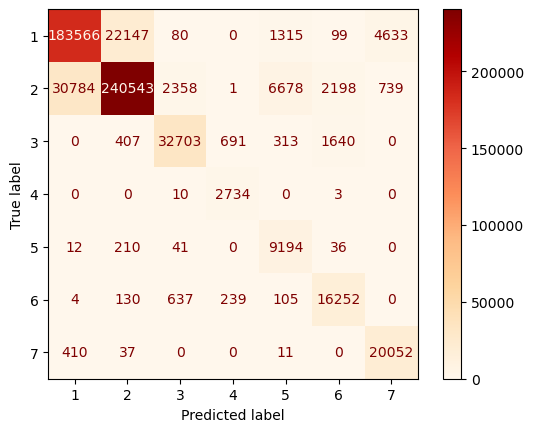

In [27]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

pred = pd.read_csv("Final_pred_best_0.86928.csv")["Cover_Type"]
true = pd.read_parquet("ground_truth.parquet")["Cover_Type"]
print(classification_report(true, pred))

ConfusionMatrixDisplay.from_predictions(true, pred, cmap="OrRd", values_format='d')

In [41]:
c = pd.read_csv('submission(1).csv')["Cover_Type"]
a = c.value_counts().values
b = [i/sum(a) for i in a]

In [42]:
b

[0.40626871734146625,
 0.3721816416872629,
 0.06584029245523328,
 0.054296641033231674,
 0.04924511025589833,
 0.04522453925220133,
 0.006943057974706202]

In [ ]:
# 0.40 0.8688426400831653
# 0.42 0.8688426400831653
# 0.44 0.8688426400831653
# 0.46 0.8688426400831653
# 0.48 0.8688426400831653
# 0.50 0.868954513848251
# 0.52 0.868954513848251
# 0.54 0.868954513848251
# 0.56 0.868954513848251
# 0.58 0.868954513848251
# 0.6 0.868954513848251
# 0.62 0.8688254287346905
# 0.64 0.8688254287346905
# 0.66 0.8688391978134703
# 0.68 0.8688391978134703
# 0.70 0.8688391978134703
# 0.72 0.8688391978134703
# 0.74 0.8688391978134703
# 0.76 0.8688391978134703
# 0.78 0.8689613983876409
# 0.78 0.8689613983876409
# 0.79 0.8689613983876409
# 0.80 0.8690285226466923
# 0.81 0.8690870412315064
# 0.82 0.8692488279071688
# 0.83 0.8692488279071688
# 0.84 0.8689717251967257
# 0.85 0.8689717251967257
# 0.86 0.8689992633542852
#pour 0.83 0.8692144052102194
# Predictions/2model+clean.csv 
# 	 0.6487387523837718
# Predictions/autoML_2models.csv 
# 	 0.7919474985026127
# Predictions/2model+stack.csv 
# 	 0.4938796444823859
# Predictions/2models.csv 
# 	 0.3877338161690292
# Predictions/Submission_pas_triee.csv 
# 	 0.3877338161690292
# Predictions/soft_classif.csv.csv 
# 	 0.7977167425113423
# Predictions/RF-0.77524.csv 
# 	 0.7755089395743978
# Predictions/2model+clean.csv.csv 
# 	 0.4931102972055655

In [41]:
col = pd.DataFrame({'col_name': clf.feature_names_in_, 'value': clf.feature_importances_}).sort_values('value').col_name.values.tolist()

In [42]:
col[1:]

['log(Horizontal_Distance_To_Fire_Points)',
 'Slope',
 'Hillshade_9am',
 'log(Horizontal_Distance_To_Roadways)',
 'kmean',
 'PCA_4',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Fire_Points * Elevation',
 'Horizontal_Distance_To_Fire_Points',
 'Aspect',
 'Hillshade_Noon',
 'Horizontal_Distance_To_Roadways',
 'PCA_3',
 'Horizontal_Distance_To_Fire_Points * Horizontal_Distance_To_Roadways',
 'Horizontal_Distance_To_Hydrology',
 'Elevation * Horizontal_Distance_To_Roadways',
 'Horizontal_Distance_To_Fire_Points * Id',
 'PCA_2',
 'Soil_Type_Synth',
 'log(Id)',
 'Elevation * Id',
 'Wilderness_Area_Synth',
 'PCA_1',
 'Id',
 'Elevation']

In [39]:
X_train[col[1:].tolist()]#.loc[:,col[1:]].columns

KeyError: "['log(Horizontal_Distance_To_Fire_Points)', 'log(Horizontal_Distance_To_Roadways)', 'kmean', 'PCA_4', 'Horizontal_Distance_To_Fire_Points * Elevation', 'PCA_3', 'Horizontal_Distance_To_Fire_Points * Horizontal_Distance_To_Roadways', 'Elevation * Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points * Id', 'PCA_2', 'log(Id)', 'Elevation * Id', 'PCA_1'] not in index"

In [22]:
for i in range(5):
    print(f'Without {col[i]}')
    accuracy, _ = model(X_train, y_train, df_test, predict_true, 
        ovs1=ovs1, ovs2=ovs2,
        smote_random=smote_random, pca_random=pca_random, ext_random=ext_random,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators
        )
    print('\t', accuracy)

array(['log(Horizontal_Distance_To_Fire_Points)', 'Slope',
       'Hillshade_9am', 'log(Horizontal_Distance_To_Roadways)', 'kmean',
       'PCA_4', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Fire_Points * Elevation',
       'Horizontal_Distance_To_Fire_Points', 'Aspect', 'Hillshade_Noon',
       'Horizontal_Distance_To_Roadways', 'PCA_3',
       'Horizontal_Distance_To_Fire_Points * Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Hydrology',
       'Elevation * Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points * Id', 'PCA_2',
       'Soil_Type_Synth', 'log(Id)', 'Elevation * Id',
       'Wilderness_Area_Synth', 'PCA_1', 'Id', 'Elevation'], dtype=object)

In [4]:
from sklearn.calibration import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.compose import make_column_transformer
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import OneHotEncoder, SplineTransformer, StandardScaler
from imblearn.over_sampling import SVMSMOTE
# from utils import clean_predictor
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import xgboost as xgb 
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

def get_data_train(DATA_PATH=''):
    return pd.read_csv(DATA_PATH+"train.csv")


def get_data_test(DATA_PATH=''):
    return pd.read_csv(DATA_PATH+"test-full.csv")

def clean_predictor(y_pred, Id=None):
    df_test = get_data_test()
    df_train = get_data_train()

    if Id is not None:
        predictions_df = pd.DataFrame(
            {'Id': Id, 'Cover_Type': y_pred})
    else:   # We assume the prediction are sorted
        predictions_df = pd.DataFrame({'Cover_Type': y_pred})
        predictions_df['Id'] = range(1, len(df_test) + 1)

    # Removing those in df_train
    predictions_df.drop(predictions_df[predictions_df["Id"].isin(
        df_train["Id"])].index, inplace=True)

    # Adding df_train instead
    predictions_df = pd.concat(
        [df_train[['Id', 'Cover_Type']], predictions_df], axis=0, ignore_index=True)

    # Sorting by Id (just in case)
    predictions_df.sort_values("Id", inplace=True)

    return predictions_df


df_test = pd.read_csv("test-full.csv")
df_train = pd.read_csv("train.csv")
predict_true = pd.read_parquet("ground_truth.parquet")["Cover_Type"]
predict_best = pd.read_csv("test_predictions_best.csv")["Cover_Type"]

# Un-one-hot-encoding the categorical variables
soil_types = [f"Soil_Type{i}" for i in range(1, 41)]
wilderness_areas = [f"Wilderness_Area{i}" for i in range(1,5)]
df_test["Wilderness_Area_Synth"] = df_test[wilderness_areas] @ range(1,5)
df_train["Wilderness_Area_Synth"] = df_train[wilderness_areas] @ range(1,5)
df_test["Soil_Type_Synth"] = df_test[soil_types] @ range(1,41)
df_train["Soil_Type_Synth"] = df_train[soil_types] @ range(1,41)
df_train = df_train.drop(columns=wilderness_areas + soil_types)
df_test = df_test.drop(columns=wilderness_areas + soil_types)

### 1. OVERSAMPLING CLASS 2 AND 1
ovs_strat = {1: 30_000, 2: 35_000}

# Separating train 
X_train = df_train.drop(columns=['Cover_Type'], axis=1)
y_train = df_train['Cover_Type']
base_cols = list(X_train.columns)
# X_train.drop(columns=['Slope', 'Hillshade_3pm'], axis=1, inplace=True)
# df_test.drop(columns=['Slope', 'Hillshade_3pm'], axis=1, inplace=True)


# Oversampling
svmsmote = SVMSMOTE(sampling_strategy=ovs_strat, random_state=1)
X_train_synth, y_train_synth = svmsmote.fit_resample(X_train, y_train)
X_train_synth = pd.DataFrame(X_train_synth, columns=X_train.columns)

# Baseline to evaluate
# clf = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=403)#np.random.randint(500))
# clf = ExtraTreesClassifier(n_estimators=150, max_features=None, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
clf = xgb.XGBRFClassifier(objective='multi:softmax', eval_metric='mlogloss', num_class=7, max_depth=8, eta=0.1)
# clf = GradientBoostingClassifier(n_estimators=150, max_depth=8)
# cat_col=X_train_synth.select_dtypes(include=object).columns
# clf = HistGradientBoostingClassifier(categorical_features=cat_col)


# clf.fit(X_train_synth, y_train_synth)
# y_pred = clf.predict(df_test)
# predictions_df = clean_predictor(y_pred)
print(f"Current best: {accuracy_score(predict_best, predict_true)}")
# print(f"Base score: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")

##### COMBINING
mult_combinator = {"Horizontal_Distance_To_Fire_Points": ["Id", "Elevation", "Horizontal_Distance_To_Roadways", 
                                            "Hillshade_9am", "Hillshade_Noon"],
              "Horizontal_Distance_To_Roadways": ["Id", "Elevation", "Hillshade_Noon"],
              "Id": ["Elevation"]}

new_cols = []
for key in mult_combinator:
    for value in mult_combinator[key]:
        new_cols.append(f"{key} * {value}")
        df_test[f"{key} * {value}"] = df_test[key] * df_test[value]    
        X_train_synth[f"{key} * {value}"] = X_train_synth[key] * X_train_synth[value]   

# # Evaluating        
# clf.fit(X_train_synth, y_train_synth)
# y_pred = clf.predict(df_test)
# predictions_df = clean_predictor(y_pred)
# print(f"With mult features: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")

# Log and square features
log_combinator = ['Id', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
square_combinator = ['Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']

for label in log_combinator:
    temp = np.where(df_test[label] > 0, df_test[label], -10)
    df_test[f"log({label})"] = np.log(temp, where=temp > 0)
    temp = np.where(X_train_synth[label] > 0, X_train_synth[label], -10)
    X_train_synth[f"log({label})"] = np.log(temp, where=temp > 0)
    
for label in square_combinator:
    df_test[f"{label}^2"] = df_test[label]**2
    X_train_synth[f"{label}^2"] = X_train_synth[label]**2
    
# clf.fit(X_train_synth, y_train_synth)
# y_pred = clf.predict(df_test)
# predictions_df = clean_predictor(y_pred)
# print(f"With all new features: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")
        
### 2. KMEANS 

# With ID
km_test = KMeans(n_clusters=25, n_init=5, init="k-means++")
km_test.fit_predict(df_test.loc[:, "Id": "Horizontal_Distance_To_Fire_Points"])
df_test["kmean_cluster"] = km_test.labels_
X_train_synth["kmean_cluster"] = km_test.predict(X_train_synth.loc[:, "Id": "Horizontal_Distance_To_Fire_Points"])

# # Evaluating
# clf.fit(X_train_synth[base_cols + new_cols + ["kmean_cluster"]], y_train_synth)
# y_pred = clf.predict(df_test[base_cols + new_cols + ["kmean_cluster"]])
# predictions_df = clean_predictor(y_pred)
# print(f"New features + kmeansID: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")

# Without ID
km = KMeans(n_clusters=12, n_init=5, init="k-means++")
df_test["kmean_2"] = km.fit_predict(df_test.loc[:, "Elevation": "Horizontal_Distance_To_Fire_Points"])
X_train_synth["kmean_2"] = km.predict(X_train_synth.loc[:, "Elevation": "Horizontal_Distance_To_Fire_Points"])

# # Evaluating
# clf.fit(X_train_synth[base_cols + new_cols + ["kmean_2"]], y_train_synth)
# y_pred = clf.predict(df_test[base_cols + new_cols + ["kmean_2"]])
# predictions_df = clean_predictor(y_pred)
# print(f"New features + kmeansNoID: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")

# # Evaluating both KM
# clf.fit(X_train_synth[base_cols + new_cols + ["kmean_cluster", "kmean_2"]], y_train_synth)
# y_pred = clf.predict(df_test[base_cols + new_cols + ["kmean_cluster", "kmean_2"]])
# predictions_df = clean_predictor(y_pred)
# print(f"New features + 2 KM: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")

### 3. PCA

# With ID
pca_1 = PCA(n_components=4)
pca_cols_1 = ["PCA_1", "PCA_2", "PCA_3", "PCA_4"]
df_test.loc[:, pca_cols_1] = pca_1.fit_transform(df_test.loc[:, "Id": "Horizontal_Distance_To_Fire_Points"])
X_train_synth.loc[:, pca_cols_1] = pca_1.transform(X_train_synth.loc[:, "Id": "Horizontal_Distance_To_Fire_Points"])

# # Evaluating
# clf.fit(X_train_synth[base_cols + new_cols + pca_cols_1], y_train_synth)
# y_pred = clf.predict(df_test[base_cols + new_cols + pca_cols_1])
# predictions_df = clean_predictor(y_pred)
# print(f"New features + pcaID: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")

# Without ID
pca_2 = PCA(n_components=2)
pca_cols_2 = ["PCA_5", "PCA_6"]
df_test.loc[:, pca_cols_2] = pca_2.fit_transform(df_test.loc[:, "Elevation": "Horizontal_Distance_To_Fire_Points"])
X_train_synth.loc[:, pca_cols_2] = pca_2.transform(X_train_synth.loc[:, "Elevation": "Horizontal_Distance_To_Fire_Points"]) 

# # Evaluating
# clf.fit(X_train_synth[base_cols + new_cols + pca_cols_2], y_train_synth)
# y_pred = clf.predict(df_test[base_cols + new_cols + pca_cols_2])
# predictions_df = clean_predictor(y_pred)
# print(f"New features + pcaNoID: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")

# # Evaluating both PCAs
# clf.fit(X_train_synth[base_cols + new_cols + pca_cols_1 + pca_cols_2], y_train_synth)
# y_pred = clf.predict(df_test[base_cols + new_cols + pca_cols_1 + pca_cols_2])
# predictions_df = clean_predictor(y_pred)
# print(f"New features + 2 PCA: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")

# to_delete = ['kmean_2', ]

# X_train_synth.drop(columns=to_del[:6], inplace=True)
# df_test.drop(columns=to_del[:6], inplace=True)

le = LabelEncoder()
### 4. EVALUATING OVERALL
clf.fit(X_train_synth, le.fit_transform(y_train_synth))
y_pred = clf.predict(df_test)
predictions_df = clean_predictor(y_pred)

# Having it fit the desired format
print(f"New features + All unsupervised: {accuracy_score(predictions_df['Cover_Type']+1, predict_true)}")
predictions_df.to_csv('test_predictions.csv', index=False) 

Current best: 0.8656912421774421
New features + All unsupervised: 0.7833332185910101


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

target = 'CoverType'
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [11]:
np.arange(100, 301, 20)

array([100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300])

In [ ]:
# clf = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=403)#np.random.randint(500))
# clf = ExtraTreesClassifier(n_estimators=150, max_features=None, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)

for mss in [2, 10, 30, 50]:
    for msl in [0.01, 0.05, 0.1, 1]:
        clf = xgb.XGBRFClassifier(objective='multi:softmax', eval_metric='mlogloss', num_class=7, max_depth=20, eta=0.1, n_estimators=100,min_samples_split=mss, min_samples_leaf=msl)
        # clf = GradientBoostingClassifier(n_estimators=150, max_depth=8)
        # cat_col=X_train_synth.select_dtypes(include=object).columns
        # clf = HistGradientBoostingClassifier(categorical_features=cat_col)

        le = LabelEncoder()
        ### 4. EVALUATING OVERALL
        clf.fit(X_train_synth, le.fit_transform(y_train_synth))
        y_pred = clf.predict(df_test)
        predictions_df = clean_predictor(y_pred)

        # Having it fit the desired format
        print(f"msl={msl}, mss={mss}: {accuracy_score(predictions_df['Cover_Type']+1, predict_true)}")
        # predictions_df.to_csv('test_predictions.csv', index=False) 

16: 0.8286128341583306
18: 0.8289828781505373
20: 0.8294906129305419


In [45]:
from sklearn.ensemble import BaggingClassifier
clf = xgb.XGBRFClassifier(objective='multi:softmax', eval_metric='mlogloss', num_class=7, max_depth=15, eta=0.1, n_estimators=100)
# clf = ExtraTreesClassifier(n_estimators=150, max_features=None, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)

bagged_trees = BaggingClassifier(
    estimator=clf,
    n_estimators=10,
)
bagged_trees.fit(X_train_synth, le.fit_transform(y_train_synth))
y_pred = bagged_trees.predict(df_test)
predictions_df = clean_predictor(y_pred)

# Having it fit the desired format
print(f": {accuracy_score(predictions_df['Cover_Type']+1, predict_true)}")

: 0.8283856443584642


In [43]:
pred2

,Id,Cover_Type
15120,1,4.00
15121,2,4.00
15122,3,1.18
15123,4,2.50
10190,5,5.00
...,...,...
581007,581008,2.00
581008,581009,2.00
581009,581010,2.00
581010,581011,2.00


In [24]:
le.fit_transform(y_train_synth)

array([0, 0, 0, ..., 1, 1, 1])

In [9]:
cat_col = X_train_synth.select_dtypes(include=object).columns
num_col = X_train_synth.select_dtypes(exclude=object).columns
preprocessor = make_column_transformer(
    # (
    #     OneHotEncoder(handle_unknown="ignore", min_frequency=0.01),
    #     cat_col,
    # ),
    (SplineTransformer(), num_col),
)
clf = make_pipeline(
    preprocessor,
    Nystroem(kernel='poly', degree=2, n_components=300),
    # RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=np.random.randint(500))
    ExtraTreesClassifier(n_estimators=150, random_state=np.random.randint(500),max_features=None, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
)
### 4. EVALUATING OVERALL
clf.fit(X_train_synth, y_train_synth)
y_pred = clf.predict(df_test)
predictions_df = clean_predictor(y_pred)

# Having it fit the desired format
print(f"New features + All unsupervised: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")
predictions_df.to_csv('test_predictions.csv', index=False) 

New features + All unsupervised: 0.8413698856478007


In [77]:
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector

# # assume X is your dataset and y is your target variable
# selector = SelectKBest(chi2, k=20)
# selected_features = selector.fit_transform(X_train_synth, y_train_synth)

sfs = SequentialFeatureSelector(clf, n_features_to_select='auto', tol=0.0001, scoring='accuracy', cv=5)
sfs.fit(X_train_synth, y_train_synth)

SequentialFeatureSelector(estimator=RandomForestClassifier(n_estimators=150,
                                                           n_jobs=-1,
                                                           random_state=403),
                          scoring='accuracy', tol=0.0001)

In [78]:
sfs.get_support()

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False,  True,  True,  True, False, False, False])

In [81]:
test = sfs.get_feature_names_out()
test

array(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_Synth',
       'Soil_Type_Synth', 'log(Id)', 'kmean_cluster', 'PCA_1', 'PCA_2',
       'PCA_3'], dtype=object)

In [82]:
clf.random_state

403

In [70]:
to_del[:7]

['kmean_2',
 'Slope',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points^2',
 'log(Horizontal_Distance_To_Roadways)',
 'log(Horizontal_Distance_To_Fire_Points)',
 'Horizontal_Distance_To_Fire_Points * Hillshade_Noon']

In [61]:
data = pd.concat([X_train_synth,y_train_synth], axis=1)

In [63]:
tmp = {}
to_del = []
for i in range(15):
    tmp[i] = [clf.feature_names_in_, clf.feature_importances_] 
    
    least_important = list(clf.feature_names_in_).pop(np.argsort(clf.feature_importances_)[0])
    print('Delete: ',least_important)
    X_train_synth.drop(columns=[least_important], inplace=True)
    df_test.drop(columns=[least_important], inplace=True)
    to_del.append(least_important)

    clf.fit(X_train_synth, y_train_synth)
    y_pred = clf.predict(df_test)
    predictions_df = clean_predictor(y_pred)
    # Having it fit the desired format
    print(f"New features + All unsupervised: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")
    # predictions_df.to_csv(f'test_predictions.csv', index=False) 

Delete:  kmean_2
New features + All unsupervised: 0.8624400184505656
Delete:  Slope
New features + All unsupervised: 0.863045857916876
Delete:  Hillshade_3pm
New features + All unsupervised: 0.8625845937777533
Delete:  Horizontal_Distance_To_Fire_Points^2
New features + All unsupervised: 0.8631732218955891
Delete:  log(Horizontal_Distance_To_Roadways)
New features + All unsupervised: 0.862187011627987
Delete:  log(Horizontal_Distance_To_Fire_Points)
New features + All unsupervised: 0.8629047248593833
Delete:  Horizontal_Distance_To_Fire_Points * Hillshade_Noon
New features + All unsupervised: 0.863180106434979
Delete:  Horizontal_Distance_To_Roadways
New features + All unsupervised: 0.8626086896656179
Delete:  Hillshade_Noon
New features + All unsupervised: 0.8628410428700268
Delete:  Horizontal_Distance_To_Fire_Points * Hillshade_9am
New features + All unsupervised: 0.8620166192780871
Delete:  kmean_cluster
New features + All unsupervised: 0.8626121319353128
Delete:  Vertical_Distance

In [66]:
clf.random_state

403

In [65]:
for v in tmp.values():
    print(v[0][np.argsort(v[1])][:5])

['kmean_2' 'Slope' 'Hillshade_3pm'
 'log(Horizontal_Distance_To_Fire_Points)'
 'Horizontal_Distance_To_Fire_Points^2']
['Slope' 'Hillshade_3pm' 'log(Horizontal_Distance_To_Fire_Points)'
 'Horizontal_Distance_To_Fire_Points^2'
 'Horizontal_Distance_To_Fire_Points']
['Hillshade_3pm' 'Horizontal_Distance_To_Fire_Points'
 'log(Horizontal_Distance_To_Fire_Points)'
 'Horizontal_Distance_To_Fire_Points^2'
 'Horizontal_Distance_To_Roadways^2']
['Horizontal_Distance_To_Fire_Points^2'
 'Horizontal_Distance_To_Fire_Points'
 'log(Horizontal_Distance_To_Fire_Points)'
 'Horizontal_Distance_To_Fire_Points * Hillshade_Noon'
 'Horizontal_Distance_To_Fire_Points * Hillshade_9am']
['log(Horizontal_Distance_To_Roadways)'
 'log(Horizontal_Distance_To_Fire_Points)'
 'Horizontal_Distance_To_Fire_Points' 'Horizontal_Distance_To_Roadways^2'
 'Horizontal_Distance_To_Roadways']
['log(Horizontal_Distance_To_Fire_Points)'
 'Horizontal_Distance_To_Fire_Points'
 'Horizontal_Distance_To_Fire_Points * Hillshade_Noon'


In [42]:
print(clf.random_state)

282


In [5]:
# Delete:  kmean_2
# New features + All unsupervised: 0.8629890604669095
# Delete:  Slope
# New features + All unsupervised: 0.862474441147515
# Delete:  Hillshade_3pm
# New features + All unsupervised: 0.8620871858068336
# Delete:  Horizontal_Distance_To_Fire_Points^2
# New features + All unsupervised: 0.8626379489580249
# Delete:  Horizontal_Distance_To_Roadways
# New features + All unsupervised: 0.8625157483838544
# Delete:  log(Horizontal_Distance_To_Fire_Points)
# New features + All unsupervised: 0.8621457043916477
# Delete:  Horizontal_Distance_To_Fire_Points * Hillshade_Noon
# New features + All unsupervised: 0.8621422621219528
# Delete:  log(Horizontal_Distance_To_Roadways)
# New features + All unsupervised: 0.8617412377024916
# Delete:  kmean_cluster
# New features + All unsupervised: 0.8636413705741017
# Delete:  Horizontal_Distance_To_Fire_Points * Hillshade_9am
# New features + All unsupervised: 0.8632696054470476

# Current best: 0.8656912421774421
# Base score: 0.8482750786558625
# With mult features: 0.8628031779033823
# With all new features: 0.8627274479700936
# New features + kmeansID: 0.8626396700928725
# New features + kmeansNoID: 0.8617963140176107
# New features + 2 KM: 0.8632489518288778
# New features + pcaID: 0.8633195183576243
# New features + pcaNoID: 0.8623247024157848
# New features + 2 PCA: 0.8641921337252931
# New features + All unsupervised: 0.8626276221489402

print(clf.feature_importances_)
print(clf.feature_names_in_)
print(clf.feature_names_in_[:20])

[0.0649774  0.12178027 0.0181831  0.01204682 0.02255579 0.01900052
 0.01640125 0.01746187 0.01657929 0.0141617  0.01447538 0.04568524
 0.05768906 0.02615949 0.01795495 0.01983697 0.01620867 0.01531837
 0.02886415 0.02063302 0.01696466 0.05529533 0.06621734 0.01565964
 0.01464653 0.01611607 0.01499848 0.02053506 0.00405167 0.0655281
 0.03205443 0.01856816 0.03040658 0.02431846 0.01866617]
['Id' 'Elevation' 'Aspect' 'Slope' 'Horizontal_Distance_To_Hydrology'
 'Vertical_Distance_To_Hydrology' 'Horizontal_Distance_To_Roadways'
 'Hillshade_9am' 'Hillshade_Noon' 'Hillshade_3pm'
 'Horizontal_Distance_To_Fire_Points' 'Wilderness_Area_Synth'
 'Soil_Type_Synth' 'Horizontal_Distance_To_Fire_Points * Id'
 'Horizontal_Distance_To_Fire_Points * Elevation'
 'Horizontal_Distance_To_Fire_Points * Horizontal_Distance_To_Roadways'
 'Horizontal_Distance_To_Fire_Points * Hillshade_9am'
 'Horizontal_Distance_To_Fire_Points * Hillshade_Noon'
 'Horizontal_Distance_To_Roadways * Id'
 'Horizontal_Distance_To_Ro

In [7]:
importance_scores = clf.feature_importances_
top_feature_indices = np.argsort(importance_scores)[-15:]
top_feature_names = [X_train_synth.columns.tolist()[i] for i in top_feature_indices]

In [13]:
clf.feature_importances_

array([0.0649774 , 0.12178027, 0.0181831 , 0.01204682, 0.02255579,
       0.01900052, 0.01640125, 0.01746187, 0.01657929, 0.0141617 ,
       0.01447538, 0.04568524, 0.05768906, 0.02615949, 0.01795495,
       0.01983697, 0.01620867, 0.01531837, 0.02886415, 0.02063302,
       0.01696466, 0.05529533, 0.06621734, 0.01565964, 0.01464653,
       0.01611607, 0.01499848, 0.02053506, 0.00405167, 0.0655281 ,
       0.03205443, 0.01856816, 0.03040658, 0.02431846, 0.01866617])

In [19]:
a = clf.feature_names_in_
a

array(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_Synth',
       'Soil_Type_Synth', 'Horizontal_Distance_To_Fire_Points * Id',
       'Horizontal_Distance_To_Fire_Points * Elevation',
       'Horizontal_Distance_To_Fire_Points * Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points * Hillshade_9am',
       'Horizontal_Distance_To_Fire_Points * Hillshade_Noon',
       'Horizontal_Distance_To_Roadways * Id',
       'Horizontal_Distance_To_Roadways * Elevation',
       'Horizontal_Distance_To_Roadways * Hillshade_Noon',
       'Id * Elevation', 'log(Id)',
       'log(Horizontal_Distance_To_Roadways)',
       'log(Horizontal_Distance_To_Fire_Points)',
       'Horizontal_Distance_To_Roadways^2',
       'Horizontal_Distance_To_Fire